## One-hot encode data

In [33]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_pickle("data/dataset_master_pickled")

RDKit WARNING: [10:24:34] Enabling RDKit 2019.09.1 jupyter extensions


In [4]:
display(data.shape)
print(data.columns)

(4784, 10)

Index(['KEGG_ID', 'ATC_class', 'primary_name', 'PubChem_SID', 'PubChem_CID',
       'MolecularFormula', 'MolecularWeight', 'CanonicalSMILES', 'Molecule',
       'FP2'],
      dtype='object')


In [5]:
y = data[["ATC_class"]]

In [6]:
enc = OneHotEncoder()
enc.fit(y)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [7]:
Y_transformed = enc.transform(data[["ATC_class"]]).toarray()
Y_transformed = pd.DataFrame(Y_transformed)
# class IDs as column names
Y_transformed.columns = list(itertools.chain(*enc.categories_))

In [8]:
data_new = pd.concat([data, Y_transformed], axis=1)
data_new.shape

(4784, 24)

## Collapse compounds with multiple classes into one record

In [9]:
# get list of KEGG_IDs with multiple records
class_count_info = data["KEGG_ID"].value_counts()
# split into records with only one class and multiple classes
single_class = list(class_count_info[class_count_info == 1].index)
multi_class = list(class_count_info[class_count_info > 1].index)

In [10]:
# simply copy single class records into a new variable
data_final = data_new[data_new['KEGG_ID'].isin(single_class)].copy()

# add multi_class records into the final table
data_new_single_class = pd.DataFrame()
for ID in multi_class:
    df = data_new[data_new["KEGG_ID"] == ID]
    compound_metadata = df.iloc[[0],:10].copy()
    class_info = pd.DataFrame(df.iloc[:,10:24].copy().sum()).transpose()
    # display(compound_metadata)
    # display(class_info)
    new_row = pd.concat([compound_metadata.reset_index(drop=True), class_info], axis=1)
    # display(new_row)
    data_final = pd.concat([data_final, new_row])
    
data_final.reset_index(drop=True, )
data_final.drop(columns="ATC_class", inplace=True)

In [11]:
data_final.head(2)

KEGG_ID                  primary_name PubChem_SID PubChem_CID  \
0  D00002                       Nadide      7847070        5893   
1  D00006  Pyridoxal phosphate hydrate      7847074       38882   

  MolecularFormula  MolecularWeight  \
0   C21H28N7O14P2+           664.40   
1        C8H12NO7P           265.16   

                                     CanonicalSMILES  \
0  C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...   
1                  CC1=NC=C(C(=C1O)C=O)COP(=O)(O)O.O   

                                           Molecule  \
0  <rdkit.Chem.rdchem.Mol object at 0x7fb818566170>   
1  <rdkit.Chem.rdchem.Mol object at 0x7fb81c5da970>   

                                                 FP2   S1  ...  S13  S14   S2  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  1.0  ...  0.0  0.0  0.0   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  1.0  ...  0.0  0.0  0.0   

    S3   S4   S5   S6   S7   S8   S9  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 23 columns]

In [12]:
sum(data_final.iloc[:,9:23].sum())

4784.0

### Pickle and save

In [13]:
# drop also molecule column
data_final.drop(columns="Molecule", inplace=True)

In [14]:
data_final.to_pickle("data/dataset_master_multiclass_encoded_pickled")

## Encode class info as one-hot numpy array

In [31]:
data_2 = data_final.iloc[:,[0] + list(range(8,22))].reset_index(drop = True)
data_2.head()

KEGG_ID   S1  S10  S11  S12  S13  S14   S2   S3   S4   S5   S6   S7   S8  \
0  D00002  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  D00006  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  D00015  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  D00028  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  D00029  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    S9  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [35]:
labels_array = []
for i in range(data_2.shape[0]):
    labels_array.append(np.array(data_2.iloc[i, 1:]))
data_2['labels'] = labels_array

In [37]:
display(data_2.tail())

KEGG_ID   S1  S10  S11  S12  S13  S14   S2   S3   S4   S5   S6   S7   S8  \
3792  D03826  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3793  D00997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3794  D01976  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3795  D01047  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
3796  D00127  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       S9                                             labels  
3792  0.0  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...  
3793  1.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  
3794  0.0  [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
3795  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  
3796  1.0  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...

In [38]:
data_2_final = data_2[["KEGG_ID", "labels"]]

In [41]:
data_2_final.sample(n = 8, random_state=42)

KEGG_ID                                             labels
298   D07586  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3079  D01137  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1361  D02190  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2712  D07367  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2417  D07298  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3358  D07517  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
402   D07064  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
321   D08266  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

### Pickle and save

In [42]:
data_2_final.to_pickle("data/dataset_master_multiclass_numpy_array_encoded_pickled")

### Appendix: look at class number distribution

In [3]:
df = pd.read_pickle("data/dataset_master_multiclass_numpy_array_encoded_pickled")

In [13]:
no_labs = []
for i in range(df.shape[0]):
    no_labs.append(sum(df.loc[i][1]))

In [17]:
df["no_labs"] = no_labs

In [25]:
no_dist = df.groupby('no_labs').count()

In [30]:
n = no_dist.reset_index()

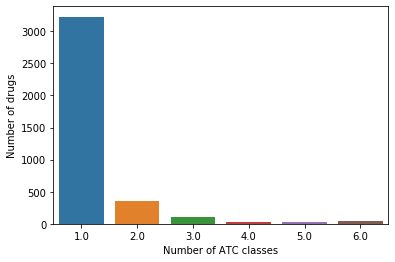

In [48]:
ax = sns.barplot(x=n['no_labs'], y=n['labels'])
ax.set(xlabel='Number of ATC classes', ylabel='Number of drugs')
plt.savefig("data/ATC_class_numbers.svg", format="svg")